In [1]:
import time
start = time.time()

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string
import hdbscan

import preprocessor as p

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('octopus_energy_tweets.csv')
df.rename(columns={"tweet":"comments"},inplace=True)
df.head()

,Unnamed: 0,comments
0,0,@octopus_energy I think your wheel is broken 🤣...
1,1,Our 3 stories of the week...\n\nNo 3: Kind cou...
2,2,@adamtranter Glad I jumped ship ages ago. Hope...
3,3,@newelland @octopus_energy I get that HRM is u...
4,4,@newelland @octopus_energy I've also wondered ...


In [4]:
df.comments.replace("\n" , " ", regex=True, inplace = True)
df.comments=df.comments.apply(lambda x:p.clean(str(x)))

In [5]:
def word_root(text):
    lemma="i"
    list_data3=[]
    doc = nlp(text)
    for token in doc:
        if token.text.isalpha():
            lemma = token.lemma_
        if len(lemma)>2:
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)
df.comments = df.comments.apply(lambda x: word_root(str(x).lower()))  

In [6]:
df.replace('nan', np.nan, inplace = True)
df.replace('', np.nan, inplace = True)
df.replace('do', np.nan, inplace = True)
df = df.dropna()
df.reset_index(drop=True,inplace=True)

In [7]:
list_data = df.comments.unique().tolist()

In [8]:
from sentence_transformers import SentenceTransformer

In [9]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1
# roberta-large-nli-stsb-mean-tokens
#allenai-specter


In [10]:
%%time
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Wall time: 48 s


In [11]:
%%time
best_model = umap.UMAP(n_components=5,min_dist=0.0).fit_transform(embeddings)

#n_neighbors=10, min_dist=0.0, 

Wall time: 10.5 s


In [12]:
import joblib
joblib.dump(best_model, "Octopus_twitter_model")

['Octopus_twitter_model']

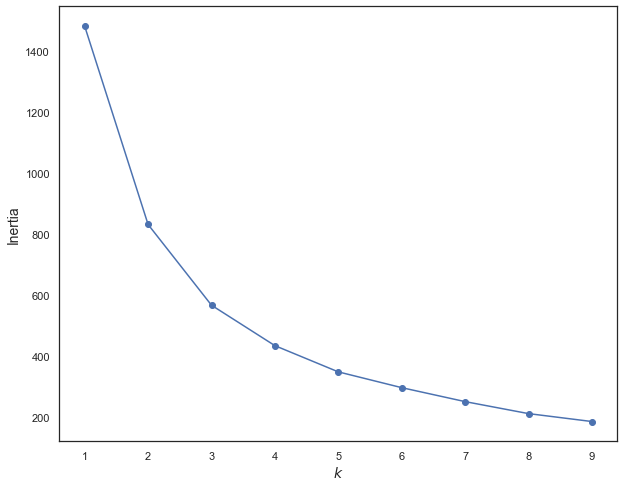

In [26]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [27]:
# from nltk.cluster import KMeansClusterer,euclidean_distance
# clusterer =KMeansClusterer(6,euclidean_distance)
# cluster=np.array(clusterer.cluster(best_model,True))

In [28]:
# cluster = KMeans(n_clusters=1, init="k-means++").fit_predict(best_model)

In [12]:
cluster = hdbscan.HDBSCAN().fit_predict(best_model)

In [13]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='hsv')
    plt.show()

{-1: 137, 0: 29, 1: 31, 2: 16, 3: 8, 4: 15, 5: 80, 6: 34, 7: 15, 8: 10, 9: 16, 10: 46, 11: 8, 12: 10, 13: 6, 14: 37}


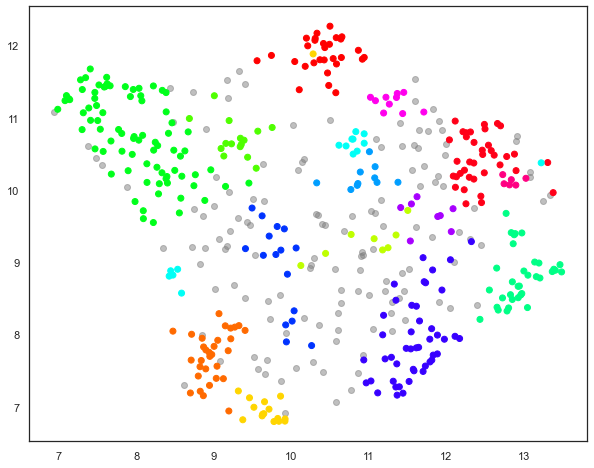

In [14]:
plot()

In [32]:
len(cluster)

498

In [18]:
# stopwords = nlp.Defaults.stop_words

In [19]:
def word_root(text):
    lemma="i"
    list_data3=[]
    doc = nlp(text)
    for token in doc:
        if token.text.isalpha():
            lemma = token.lemma_
        if len(lemma)>2:
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)

In [15]:
docs = pd.DataFrame(list_data,columns=["comments"])
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"comments": " ".join})
# labeled_docs.comments = labeled_docs.comments.apply(lambda x: word_root(str(x).lower()))  
labeled_docs

,cluster,comments
0,-1,yeah yeah hear hear mostly mostly good thing a...
1,0,octopus energy help natwest group group custom...
2,1,love this adorable adorable big one one that f...
3,2,have thank thank thank for sharing sharing luc...
4,3,think your wheel break hit and roll back back ...
5,4,just imagine the chaos chaos every uninformed ...
6,5,get that hrm use exert control over employee e...
7,6,can have timetable for smart meter roll out ou...
8,7,see this this this meet michael liebreich lieb...
9,8,forget you can join and split and have the sha...


In [21]:
# counts = pd.Series(' '.join(labeled_docs['comments']).split()).value_counts()[:100].index

In [34]:
labeled_docs.comments.replace(r"\S*octo\S*", "octopus", regex=True, inplace = True)

In [16]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 10 	 cluster 11 	 similarity: 0.5116
cluster 8 	 cluster 9 	 similarity: 0.4999
cluster 4 	 cluster 10 	 similarity: 0.4981
cluster 4 	 cluster 11 	 similarity: 0.4967
cluster 2 	 cluster 10 	 similarity: 0.4950
cluster 4 	 cluster 12 	 similarity: 0.4918
cluster 10 	 cluster 13 	 similarity: 0.4846
cluster 14 	 cluster 15 	 similarity: 0.4611
cluster 13 	 cluster 15 	 similarity: 0.4352
cluster 2 	 cluster 4 	 similarity: 0.4272
cluster 12 	 cluster 15 	 similarity: 0.4270
cluster 11 	 cluster 15 	 similarity: 0.4239
cluster 5 	 cluster 10 	 similarity: 0.4231
cluster 7 	 cluster 15 	 similarity: 0.4185
cluster 5 	 cluster 7 	 similarity: 0.4103
cluster 3 	 cluster 11 	 similarity: 0.4042
cluster 4 	 cluster 15 	 similarity: 0.4040
cluster 5 	 cluster 11 	 similarity: 0.3972
cluster 8 	 cluster 15 	 similarity: 0.3965
cluster 9 	 cluster 15 	 similarity: 0.3926
cluster 10 	 cluster 15 	 similarity: 0.3889
cluster 5 	 cluster 6 	 similarity: 0.3884
cluster 5 

In [17]:
%%time
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1



Wall time: 21 ms


<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)
labeled_docs

,cluster,comments
0,-1,yeah yeah hear hear mostly mostly good thing a...
1,0,octopus energy help natwest group group custom...
2,1,love this adorable adorable big one one that f...
3,2,have thank thank thank for sharing sharing luc...
4,4,just imagine the chaos chaos every uninformed ...
5,5,get that hrm use exert control over employee e...
6,7,see this this this meet michael liebreich lieb...
7,13,cent kwh kwh kwh that due cheap renewable rene...


In [19]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 6 	 cluster 7 	 similarity: 0.4089
cluster 4 	 cluster 5 	 similarity: 0.3884
cluster 1 	 cluster 3 	 similarity: 0.3255
cluster 2 	 cluster 3 	 similarity: 0.3251
cluster 1 	 cluster 4 	 similarity: 0.3106
cluster 1 	 cluster 2 	 similarity: 0.3076
cluster 4 	 cluster 6 	 similarity: 0.3073
cluster 1 	 cluster 7 	 similarity: 0.3013
cluster 2 	 cluster 4 	 similarity: 0.2923
cluster 2 	 cluster 6 	 similarity: 0.2850
cluster 1 	 cluster 6 	 similarity: 0.2766
cluster 2 	 cluster 7 	 similarity: 0.2753
cluster 2 	 cluster 5 	 similarity: 0.2716
cluster 3 	 cluster 4 	 similarity: 0.2657
cluster 5 	 cluster 6 	 similarity: 0.2318
cluster 1 	 cluster 5 	 similarity: 0.2251
cluster 4 	 cluster 7 	 similarity: 0.2248
cluster 3 	 cluster 6 	 similarity: 0.2150
cluster 3 	 cluster 7 	 similarity: 0.1699
cluster 5 	 cluster 7 	 similarity: 0.1400
cluster 3 	 cluster 5 	 similarity: 0.1114
Wall time: 2.17 s


In [20]:
%%time
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1

Wall time: 6 ms


<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\IPython\core\magics\execution.py:1321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code, glob, local_ns)
<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)
labeled_docs

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,cluster,comments
0,-1,yeah yeah hear hear mostly mostly good thing a...
1,0,octopus energy help natwest group group custom...
2,1,love this adorable adorable big one one that f...
3,2,have thank thank thank for sharing sharing luc...
4,4,just imagine the chaos chaos every uninformed ...
5,5,get that hrm use exert control over employee e...
6,7,see this this this meet michael liebreich lieb...


In [22]:
labeled_docs

,cluster,comments
0,-1,yeah yeah hear hear mostly mostly good thing a...
1,0,octopus energy help natwest group group custom...
2,1,love this adorable adorable big one one that f...
3,2,have thank thank thank for sharing sharing luc...
4,4,just imagine the chaos chaos every uninformed ...
5,5,get that hrm use exert control over employee e...
6,7,see this this this meet michael liebreich lieb...


In [23]:
%%time
from keybert import KeyBERT
array_text = labeled_docs.comments.tolist()
kw_extractor = KeyBERT(model=model)
bigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(2, 2))
    print(f'\033[1m   Bigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    bigram.append([word[0] for word in keywords])

   Bigram Cluster 1: 
[('octopus toy', 0.4473), ('octopusesese supply', 0.4277), ('toy octopusenergy', 0.426), ('octosol octosol', 0.4079), ('switch octopus', 0.4058), ('add octopus', 0.3961), ('come octoshine', 0.3938), ('octopi octopi', 0.3933), ('toy octopus', 0.3905), ('energy octopus', 0.3903)]
   Bigram Cluster 2: 
[('adorable adorable', 0.53), ('logo gorgeous', 0.5024), ('love adorable', 0.502), ('adorable big', 0.4781), ('awesome close', 0.4666), ('close awesome', 0.4534), ('lovely gesture', 0.4362), ('look big', 0.4199), ('oooh close', 0.418), ('nice nice', 0.4161)]
   Bigram Cluster 3: 
[('thank thank', 0.5978), ('offer thank', 0.5779), ('thank sharing', 0.5714), ('octopus thank', 0.5699), ('sort thank', 0.566), ('awesome thank', 0.5649), ('thank send', 0.5616), ('send thank', 0.5578), ('great thank', 0.5468), ('thankyou send', 0.5443)]
   Bigram Cluster 4: 
[('security professional', 0.4265), ('chaos protect', 0.4103), ('cybersecurity cybersecurity', 0.4059), ('cybersecurity

In [24]:
%%time
unigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(1, 1))
    print(f'\033[1m   Unigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    unigram.append([word[0] for word in keywords])

   Unigram Cluster 1: 
[('octosol', 0.3619), ('octopod', 0.3582), ('octopus', 0.3546), ('octopi', 0.3504), ('octopusenergy', 0.3492), ('octopusesese', 0.3469), ('octoshine', 0.3445), ('toy', 0.291), ('octolux', 0.2815), ('candy', 0.2558)]
   Unigram Cluster 2: 
[('adorable', 0.4948), ('lovely', 0.3954), ('gorgeous', 0.3857), ('nice', 0.3831), ('similar', 0.3807), ('cheer', 0.3762), ('excellent', 0.3671), ('kind', 0.3661), ('close', 0.3638), ('sorry', 0.3559)]
   Unigram Cluster 3: 
[('thankyou', 0.5348), ('thank', 0.4858), ('octopus', 0.2605), ('post', 0.2505), ('awesome', 0.2485), ('sharing', 0.2465), ('lucky', 0.2459), ('offer', 0.2442), ('send', 0.2365), ('pilgrim', 0.2246)]
   Unigram Cluster 4: 
[('cybersecurity', 0.3714), ('chaos', 0.2946), ('security', 0.2823), ('secure', 0.2703), ('provider', 0.2503), ('hack', 0.2472), ('confuse', 0.2445), ('worker', 0.2408), ('protect', 0.2337), ('accountant', 0.231)]
   Unigram Cluster 5: 
[('workforce', 0.3705), ('employee', 0.3433), ('emplo

In [25]:
for i in range(len(array_text)-1):
    clusterer=[]
    bigramer=[]
    print(f'\033[1m   Cluster {i+1}: \033[0m')
    [clusterer.append(j) for j in unigram[i]]
    clusterer.append(bigram[i][0])
    
    for word in bigram[i][0].split(" "):
        if word not in bigramer:
            bigramer.append(word)
    
    for each in bigram[i]:
        first,second=each.split(" ")
        if first != second and not(first in bigramer and second in bigramer):
            clusterer.append(each)
            if bigramer.append(first): first not in bigramer
            if bigramer.append(second): second not in bigramer
    print(clusterer)

   Cluster 1: 
['octosol', 'octopod', 'octopus', 'octopi', 'octopusenergy', 'octopusesese', 'octoshine', 'toy', 'octolux', 'candy', 'octopus toy', 'octopusesese supply', 'toy octopusenergy', 'switch octopus', 'add octopus', 'come octoshine', 'energy octopus']
   Cluster 2: 
['adorable', 'lovely', 'gorgeous', 'nice', 'similar', 'cheer', 'excellent', 'kind', 'close', 'sorry', 'adorable adorable', 'logo gorgeous', 'love adorable', 'adorable big', 'awesome close', 'lovely gesture', 'look big', 'oooh close']
   Cluster 3: 
['thankyou', 'thank', 'octopus', 'post', 'awesome', 'sharing', 'lucky', 'offer', 'send', 'pilgrim', 'thank thank', 'offer thank', 'thank sharing', 'octopus thank', 'sort thank', 'awesome thank', 'thank send', 'great thank', 'thankyou send']
   Cluster 4: 
['cybersecurity', 'chaos', 'security', 'secure', 'provider', 'hack', 'confuse', 'worker', 'protect', 'accountant', 'security professional', 'chaos protect', 'cybersecurity lolz', 'security people', 'fantastic security', 

In [26]:
end = time.time()
print(end - start)

181.5307514667511
